# In this notebook we have: 
- Analyzing all trajectories from **"all_trajectories"** file
- Estimating distance between each two stops of a trip in **"distance_km"** and **"distance_minutes"** column
- Estimating the number of trees around each stop in **"number_trees"** column
- Defining **"green_index"** both in time and distance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import folium

from geopy.distance import geodesic
import geopy.distance

from sklearn.neighbors import KDTree
from scipy import spatial
from scipy import stats
from scipy.spatial import distance

## Opening trajectories and trees data

In [2]:
all_tj = pd.read_csv("/content/all_trajectories.csv")
all_tj = all_tj.drop(['Unnamed: 0', 'index'], axis=1)
all_tj.head(15)

,tripIndex,lat,lon,time
0,349,41.904218,12.679084,0
1,349,41.898969,12.678453,55
2,349,41.901686,12.678275,645
3,349,41.896203,12.676946,1291
4,349,41.895846,12.675373,1292
5,349,41.895602,12.675157,1301
6,349,41.894935,12.675231,1388
7,349,41.897484,12.673911,1485
8,349,41.897205,12.678455,2560
9,4737,41.925546,12.414767,0


As 'time' column in the dataset is not showing the time spemt on each stop, we defined a new column 'corrected_time' which has the time spent on between each row. 

In [7]:
all_tj['corrected_time'] = pd.Series(dtype='int')
all_tj['corrected_time'][0] = 0

for i, row in all_tj.iterrows():
  if (i != 0) and all_tj['tripIndex'][i] == all_tj['tripIndex'][i - 1]:
      all_tj['corrected_time'][i] = all_tj['time'][i] - all_tj['time'][i - 1]
  elif (i != 0) and all_tj['tripIndex'][i] != all_tj['tripIndex'][i - 1]:
      all_tj['corrected_time'][i] = all_tj['time'][i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
all_tj.head()

,tripIndex,lat,lon,time,corrected_time
0,349,41.904218,12.679084,0,0.0
1,349,41.898969,12.678453,55,55.0
2,349,41.901686,12.678275,645,590.0
3,349,41.896203,12.676946,1291,646.0
4,349,41.895846,12.675373,1292,1.0


In [ ]:
# Opening the trees file. 
tr = pd.read_csv('/content/New_punti_with_lon_lat.csv')
# The last row has no latitude. 
tr = tr[:-1]
tr.head()

,Unnamed: 0,DESCRIZION,MUNICIPIO,CODICE_COM,CODICE_PRO,SCALA_NOMI,DATA,CARTA,DITTA,FLAG_LIM,IDENTIFICA,CODICE,CODICE_DGC,geometry,lon,lat
0,0,Albero isolato,18.0,91,58,5000,25/04/02,374053,100.0,NaN,4.000000e+11,030101S,4856.0,POINT (12.363438090987744 41.91713214136139),12.363438,41.917132
1,1,Albero isolato,18.0,91,58,5000,25/04/02,374053,100.0,NaN,4.000000e+11,030101S,4857.0,POINT (12.363299559405112 41.91748620444721),12.363300,41.917486
2,2,Albero isolato,18.0,91,58,5000,25/04/02,374053,100.0,NaN,4.000000e+11,030101S,4858.0,POINT (12.362713355865349 41.91754117154416),12.362713,41.917541
3,3,Albero isolato,18.0,91,58,5000,25/04/02,374053,100.0,NaN,4.000000e+11,030101S,4859.0,POINT (12.362958349958733 41.91705555506134),12.362958,41.917056
4,4,Albero isolato,18.0,91,58,5000,25/04/02,374053,100.0,NaN,4.000000e+11,030101S,4860.0,POINT (12.363078670324292 41.91775543401073),12.363079,41.917755


## Preparing the data for estimating the distances in km and in minutes

In [ ]:
# Putting lat-lon as a tuple to have them in this format for later uses. 

all_tj["lat-lon"] = list(zip(all_tj['lat'], all_tj['lon']))

In [ ]:
# Defining two columns of "lat_next" and "lot_next" for estimating the distance.
# It should see if the tripIndex has not been changed, get the next lat and lon.
# And if the tripIndex has changed, take the last lat and lon and put it as the next lat and lon.  

## It takes near 3 minutes to run

all_tj['lat_next'] = pd.Series(dtype='float')
all_tj['lon_next'] = pd.Series(dtype='float')

all_tj['lat_next'][len(all_tj) - 1] = all_tj['lat'][len(all_tj) - 1]
all_tj['lon_next'][len(all_tj) - 1] = all_tj['lon'][len(all_tj) - 1]


for i, row in all_tj.iterrows():
  if (i != len(all_tj) - 1) and all_tj['tripIndex'][i] == all_tj['tripIndex'][i + 1]:
      all_tj['lat_next'][i] = all_tj['lat'][i + 1]
      all_tj['lon_next'][i] = all_tj['lon'][i + 1]
  elif (i != len(all_tj) - 1) and all_tj['tripIndex'][i] != all_tj['tripIndex'][i + 1]:
      all_tj['lat_next'][i] = all_tj['lat'][i]
      all_tj['lon_next'][i] = all_tj['lon'][i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Estimating the distance in km between each two stops of trips.

def distancer(row):
    coords_1 = (row['lat'], row['lon'])
    coords_2 = (row['lat_next'], row['lon_next'])
    return geopy.distance.geodesic(coords_1, coords_2).km

all_tj['distance_km'] = all_tj.apply(distancer, axis=1)

In [ ]:
# Estimating the distance in minutes between each two stops of trips.

def distancer_in_euclidean(row):
  coords_1 = (row['lat'], row['lon'])
  coords_2 = (row['lat_next'], row['lon_next'])
  return distance.euclidean(coords_1, coords_2)

all_tj['distance_in_minutes'] = all_tj.apply(distancer_in_euclidean, axis=1)

In [ ]:
all_tj.head()

,tripIndex,lat,lon,time,lat-lon,lat_next,lon_next,distance_km,distance_in_minutes
0,349,41.904218,12.679084,0,"(41.90421784974773, 12.67908421134476)",41.898969,12.678453,0.585292,0.005286
1,349,41.898969,12.678453,55,"(41.898969469324754, 12.678453128461776)",41.901686,12.678275,0.302092,0.002722
2,349,41.901686,12.678275,645,"(41.901685997328975, 12.678274506347506)",41.896203,12.676946,0.618901,0.005642
3,349,41.896203,12.676946,1291,"(41.89620294246636, 12.676946426407458)",41.895846,12.675373,0.136472,0.001614
4,349,41.895846,12.675373,1292,"(41.89584603111947, 12.67537280875032)",41.895602,12.675157,0.032455,0.000325


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


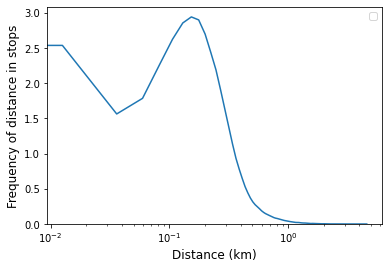

In [ ]:
# Distribution of distance in all rows (stops). You can plot it in log_scale, too.

ax = sns.distplot(all_tj['distance_km'], hist = False)
ax.set_xlabel("Distance (km)", fontsize = 12)
ax.set_ylabel("Frequency of distance in stops", fontsize = 12)
ax.set_xscale('log')
plt.legend()
plt.xlim(0)
#plt.savefig('distribution of distance in stops_logscale.png', dpi = 300)
plt.show()

## Estimating the number of trees around each stop and plotting the distribution of number of trees

In [ ]:
# Take the mean of distance both in km and minutes.

print("Mean of distance in km: ")
print(all_tj['distance_km'].mean())
print("Mean of distance in minutes: ")
print(all_tj['distance_in_minutes'].mean())

Mean of distance in km: 
0.2246162522984261
Mean of distance in minutes: 
0.002334245004013875


In [ ]:
# Converting the lat and lon columns in both dataset intpo numpy array.

points_tr = np.array(list(zip(tr['lat'], tr['lon'])))
points_tj = np.array(list(zip(all_tj['lat'], all_tj['lon'])))

In [ ]:
# Estimating the number of trees in radius R around each stop.

def number_tree(trip_stop, r, tree_df):
  tree = spatial.KDTree(points_tr)
  return tree.query_ball_point(trip_stop, r)

In [ ]:
# For the radius R, we put the mean of distances, which is equal to 220 meters.
# We add all the number of trees in a column and add it later to the dataset. 

# It takes nearly 8 minutes to run

tree = KDTree(points_tr, leaf_size=2, metric='euclidean')
number = []
for i in range(len(points_tj)):
  number.append(tree.query_radius([points_tj[i]], r = all_tj['distance_in_minutes'].mean(), count_only=True)[0])

# Adding the column to the dataset
number = np.array(number)
all_tj['number_trees'] = number

# for plotting the trips without zero number of trees around, we use another list for not changing the original list.
number_0 = number
number_0 = [i for i in number_0 if i != 0]

In [ ]:
# Estimating the number of trees in radius 320 meter as a higher radius.

# It takes near 5 minutes to run

tree = KDTree(points_tr, leaf_size=2, metric='euclidean')
number_1 = []
for i in range(len(points_tj)):
  number_1.append(tree.query_radius([points_tj[i]], r = 0.0027, count_only=True)[0])

# Remving zeros
number_1 = [i for i in number_1 if i != 0]

In [ ]:
# Estimating the number of trees in radius 50 meter as a very smaller radius.

# It takes near 5 minutes to run

tree = KDTree(points_tr, leaf_size=2, metric='euclidean')

number_2 = []
for i in range(len(points_tj)):
  number_2.append(tree.query_radius([points_tj[i]], r = 0.0006, count_only=True)[0])

# Remving zeros
number_2 = [i for i in number_2 if i != 0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


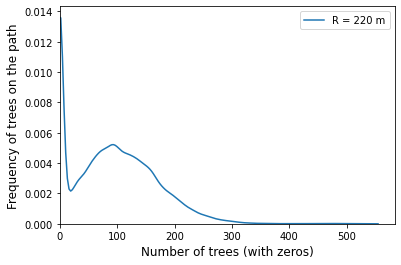

In [ ]:
# Plotting distribution of number of trees with zeros

ax = sns.distplot(number, hist = False,  label="R = 220 m")
ax.set_xlabel("Number of trees (with zeros)", fontsize = 12)
ax.set_ylabel("Frequency of trees on the path", fontsize = 12)
plt.legend()
plt.xlim(0)
#plt.savefig('number_of_trees_220m.png', dpi = 300)
plt.show()

# so it shows that most of our trips have less than 20 trees in their path.
# Although we have another pick at 100 trees which includes noticable number of trips. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


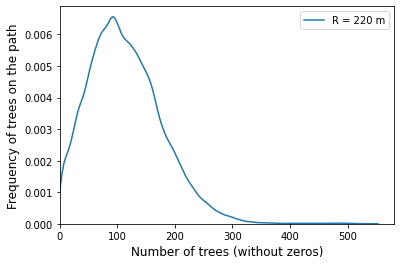

In [ ]:
ax = sns.distplot(number_0, hist = False,  label="R = 220 m")
ax.set_xlabel("Number of trees (without zeros)", fontsize = 12)
ax.set_ylabel("Frequency of trees on the path", fontsize = 12)
plt.legend()
plt.xlim(0)
#plt.savefig('number_of_trees_220m without zeros.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


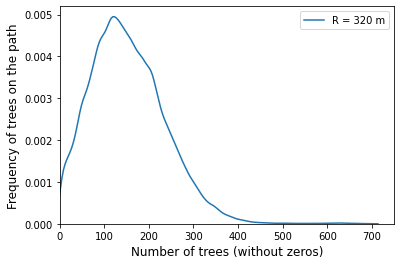

In [ ]:
ax = sns.distplot(number_1, hist = False,  label="R = 320 m")
ax.set_xlabel("Number of trees (without zeros)", fontsize = 12)
ax.set_ylabel("Frequency of trees on the path", fontsize = 12)
plt.legend()
plt.xlim(0)
#plt.savefig('number_of_trees_320m_without zeros.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


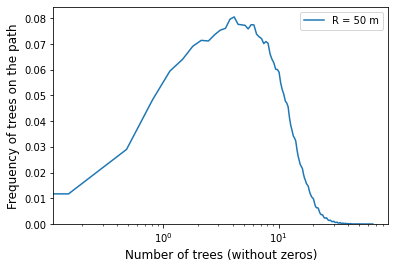

In [ ]:
ax = sns.distplot(number_2, hist = False,  label="R = 50 m")
ax.set_xlabel("Number of trees (without zeros)", fontsize = 12)
ax.set_ylabel("Frequency of trees on the path", fontsize = 12)
ax.set_xscale('log')
plt.legend()
plt.xlim(0)
#plt.savefig('number_of_trees_50m_withoutzeros.png', dpi = 300)
plt.show()

No handles with labels found to put in legend.


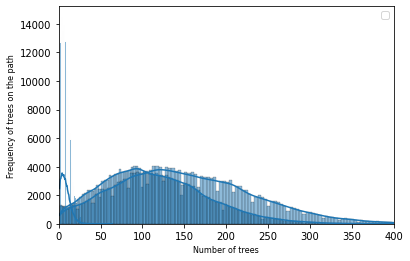

In [ ]:
# About this one we can talk to see.........................
ax = sns.histplot(x=number_0, kde=True)
ax = sns.histplot(x=number_1,kde=True)
ax = sns.histplot(x=number_2, kde=True)
ax.set_xlabel("Number of trees", fontsize = 8)
ax.set_ylabel("Frequency of trees on the path", fontsize = 8)

plt.xlim(0, 400)
plt.legend()
#plt.savefig('number_of_trees_all_three220-3201.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

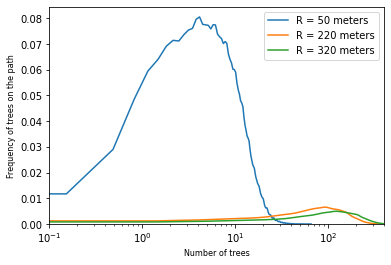

In [ ]:
target_0 = number_0 #220 meters
target_1 = number_1 #320 meters
target_2 = number_2 #50 meters

ax = sns.distplot(target_2, hist = False,  label="R = 50 meters", norm_hist=True)
ax = sns.distplot(target_0, hist = False, label="R = 220 meters",norm_hist=True)
ax = sns.distplot(target_1, hist = False,  label="R = 320 meters", norm_hist=True)


ax.set_xlabel("Number of trees", fontsize = 8)
ax.set_ylabel("Frequency of trees on the path", fontsize = 8)
ax.set_xscale('log')

plt.xlim(0, 400)
plt.legend()
#plt.savefig('number_of_trees_320 and 220.png', dpi = 300)
plt.show()

In [ ]:
# Makin two data frames with number of trees and the other one with time and merging them for plot. 

# tree_each_trip : the number of trees per each tripINDEX

tree_each_trip = all_tj.groupby(by= all_tj['tripIndex'])['number_trees'].sum()
tree_each_trip = tree_each_trip.reset_index()
tree_each_trip = tree_each_trip.sort_values('tripIndex')
tree_each_trip.head()

,tripIndex,number_trees
0,40,272
1,51,0
2,53,2248
3,59,1564
4,60,1511


In [ ]:
tree_each_trip_no_zero = tree_each_trip.loc[tree_each_trip['number_trees'] > 0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


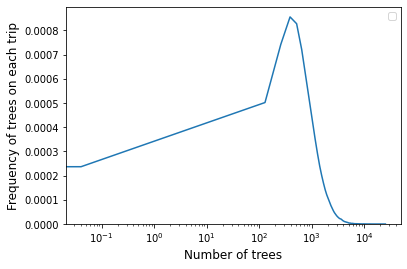

In [ ]:
ax = sns.distplot(tree_each_trip_no_zero['number_trees'], hist = False)
ax.set_xlabel("Number of trees", fontsize = 12)
ax.set_ylabel("Frequency of trees on each trip", fontsize = 12)
ax.set_xscale('log')
plt.legend()
plt.xlim(0)
plt.savefig('number_of_trees_each_trip_logscale_no_zeros.png', dpi = 300,bbox_inches="tight")
plt.show()

In [ ]:
# for creating a new dataframe with correct timing
# because in the dataset each trip whole time is actually the last time in the last row of the tripIndex. So...
trip_time = {}
for i, row in all_tj.iterrows():
    if i != 0 and all_tj['tripIndex'][i] != all_tj['tripIndex'][i - 1]:
      trip_time[all_tj['tripIndex'][i -1]] = all_tj['time'][i - 1]

In [ ]:
time_and_trip = pd.DataFrame.from_dict(trip_time, orient="index").reset_index()
time_and_trip.columns = ['tripIndex', 'time']
time_and_trip = time_and_trip.sort_values('tripIndex')
time_and_trip.head()

,tripIndex,time
25070,40,2976
12227,51,2094
2234,53,1763
11425,59,2881
16605,60,1200


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


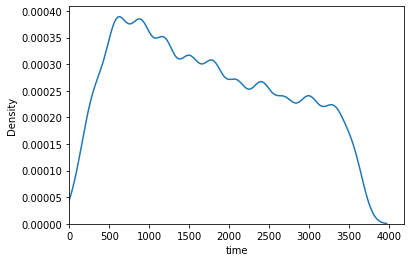

In [ ]:
ax = sns.distplot(time_and_trip['time'], hist = False)
#ax.set_xlabel('Time', fontsize = 10)
#ax.set_ylabel("Frequency of time spent on trips", fontsize = 10)
#plt.legend()
plt.xlim(0)
#plt.savefig('time spent on trips.png', dpi = 300,bbox_inches="tight")
plt.show()

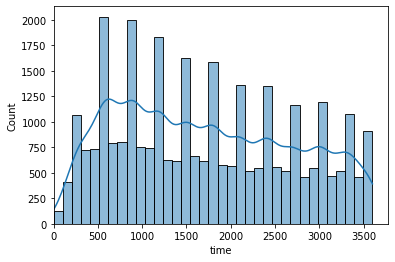

In [ ]:
ax = sns.histplot(x = time_and_trip['time'], kde=True)
#ax.set_xlabel('Time', fontsize = 10)
#ax.set_ylabel("Frequency of time spent on trips", fontsize = 10)
#plt.legend()
plt.xlim(0)
#plt.savefig('time spent on trips11.png', dpi = 300,bbox_inches="tight")
plt.show()

In [ ]:
dist_each_trip = all_tj.groupby(by= all_tj['tripIndex'])['distance_km'].sum()
dist_each_trip = dist_each_trip.reset_index()
dist_each_trip = dist_each_trip.sort_values('tripIndex')
dist_each_trip.head()

,tripIndex,distance_km
0,40,0.882902
1,51,2.574329
2,53,3.943713
3,59,3.383147
4,60,2.435823


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


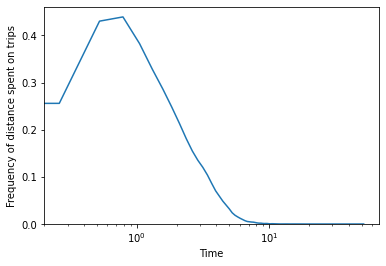

In [ ]:
ax = sns.distplot(dist_each_trip['distance_km'], hist = False)
ax.set_xlabel('Time', fontsize = 10)
ax.set_ylabel("Frequency of distance spent on trips", fontsize = 10)
#plt.legend()
ax.set_xscale('log')
plt.xlim(0)
#plt.savefig('distribution of distance in trips.png', dpi = 300,bbox_inches="tight")
plt.show()

In [ ]:
dfs = [tree_each_trip, time_and_trip, dist_each_trip]
import functools as ft
green_index_df = ft.reduce(lambda left, right: pd.merge(left, right, on='tripIndex'), dfs)

In [ ]:
# the number of trees without zeros. 
green_index_df = green_index_df[green_index_df['number_trees'] > 5]

In [ ]:
green_index_df["greenIndex_time"] = green_index_df['number_trees'] / green_index_df['time']
green_index_df["greenIndex_distance"] = green_index_df['number_trees'] / green_index_df['distance_km']

In [ ]:
green_index_df = green_index_df[green_index_df['greenIndex_time'] != 0]
green_index_df = green_index_df[green_index_df['greenIndex_distance'] != 0]

In [ ]:
green_index_df.head()

,tripIndex,number_trees,time,distance_km,greenIndex_time,greenIndex_distance
0,40,272,2976,0.882902,0.091398,308.074794
2,53,2248,1763,3.943713,1.275099,570.021245
3,59,1564,2881,3.383147,0.542867,462.291459
4,60,1511,1200,2.435823,1.259167,620.324168
5,85,142,600,0.889538,0.236667,159.633354


In [ ]:
print("Mean of GreenIndex of time is: ")
print(green_index_df['greenIndex_time'].mean())
print("Mean of GreenIndex of distance is: ")
print(green_index_df['greenIndex_distance'].mean())

Mean of GreenIndex of time is: 
0.7595672870912482
Mean of GreenIndex of distance is: 
634.9218691726605


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


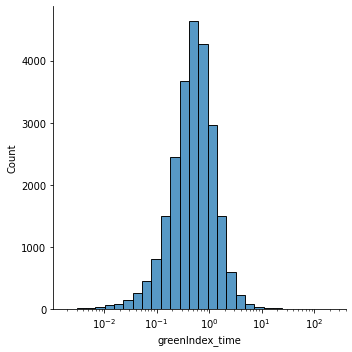

In [ ]:
ax = sns.displot(data = green_index_df['greenIndex_time'], bins = 30, log_scale=True)
plt.xlim(0, 400)
#plt.savefig('green_index_time.png', dpi = 300)

In [ ]:
green_index_df = green_index_df[np.isfinite(green_index_df['greenIndex_distance'])]
green_index_df = green_index_df[green_index_df['greenIndex_distance'] != 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


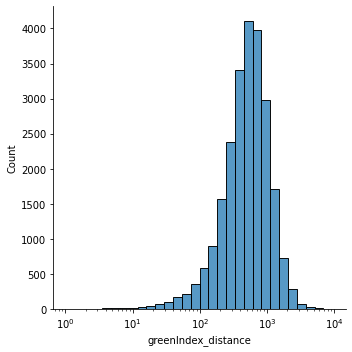

In [ ]:
ax = sns.displot(data = green_index_df['greenIndex_distance'], bins = 30, log_scale=True)
plt.xlim(0)
#plt.savefig('green_index_distance.png', dpi = 300)

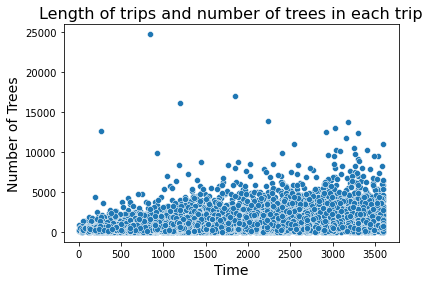

In [ ]:
sns.scatterplot(data = green_index_df, x = 'time', y = 'number_trees')
plt.title('Length of trips and number of trees in each trip', fontsize = 16)
# Set x-axis label
plt.xlabel('Time', fontsize = 14)
# Set y-axis label
plt.ylabel('Number of Trees', fontsize = 14)
#plt.savefig('scatterplot2.png', dpi = 100)
plt.show()

In [ ]:
# Gather all tripIndexes with greenIndex higher than mean, into a list. ex [#1, #32, #9894,...]
# Then with tripIndexes we should go through all_tj dataset to take all the lat and lon of these trips.
# Then we should make for each tripIndex, a coord which is a matrix of [[lat, lon][1], [lat, lon][2], ...]
# Then We can plot it in folium. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


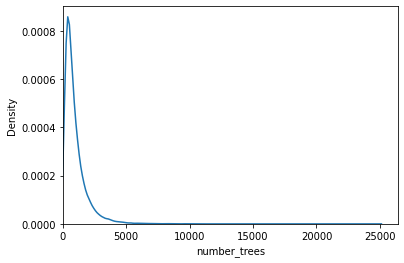

In [ ]:
ax = sns.distplot(green_index_df['number_trees'], hist = False)
plt.xlim(0)
#plt.savefig('number_trees_distribution per trip.png', dpi = 300)


In [ ]:
green_trips_time = green_index_df[green_index_df['greenIndex_time'] > green_index_df['greenIndex_time'].mean()]
green_trips_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7513 entries, 2 to 30508
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tripIndex            7513 non-null   int64  
 1   number_trees         7513 non-null   int64  
 2   time                 7513 non-null   int64  
 3   distance_km          7513 non-null   float64
 4   greenIndex_time      7513 non-null   float64
 5   greenIndex_distance  7513 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 410.9 KB


In [ ]:
green_trips_distance = green_index_df[green_index_df['greenIndex_distance'] > green_index_df['greenIndex_distance'].mean()]
green_trips_distance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9312 entries, 6 to 30515
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tripIndex            9312 non-null   int64  
 1   number_trees         9312 non-null   int64  
 2   time                 9312 non-null   int64  
 3   distance_km          9312 non-null   float64
 4   greenIndex_time      9312 non-null   float64
 5   greenIndex_distance  9312 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 509.2 KB


In [ ]:
q = green_index_df["greenIndex_time"].quantile(0.99)
q1 = green_index_df['number_trees'].quantile(0.99)
p = green_index_df["time"].quantile(0.99)

In [ ]:
# Making a df including outliers based in the number of trees
outliers_df = green_index_df[green_index_df["greenIndex_time"] > q]
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 34 to 30404
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tripIndex            239 non-null    int64  
 1   number_trees         239 non-null    int64  
 2   time                 239 non-null    int64  
 3   distance_km          239 non-null    float64
 4   greenIndex_time      239 non-null    float64
 5   greenIndex_distance  239 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 13.1 KB


In [ ]:
new_one_without_outliers = green_index_df[green_index_df["number_trees"] < q1]

In [ ]:
new_one_without_outliers['Range_of_time'] = pd.Series(dtype='float')

for i, row in new_one_without_outliers.iterrows():
    if new_one_without_outliers['time'][i] < 900:
        new_one_without_outliers['Range_of_time'][i] = "<0-15> mins"
    elif (new_one_without_outliers['time'][i] > 900) & (new_one_without_outliers['time'][i] < 1800):
        new_one_without_outliers['Range_of_time'][i] = "<15-30> mins"
    elif (new_one_without_outliers['time'][i] > 1800) & (new_one_without_outliers['time'][i] < 2700):
        new_one_without_outliers['Range_of_time'][i] = "<30-45> mins"
    else:
      new_one_without_outliers['Range_of_time'][i] = "<45-60> mins"  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

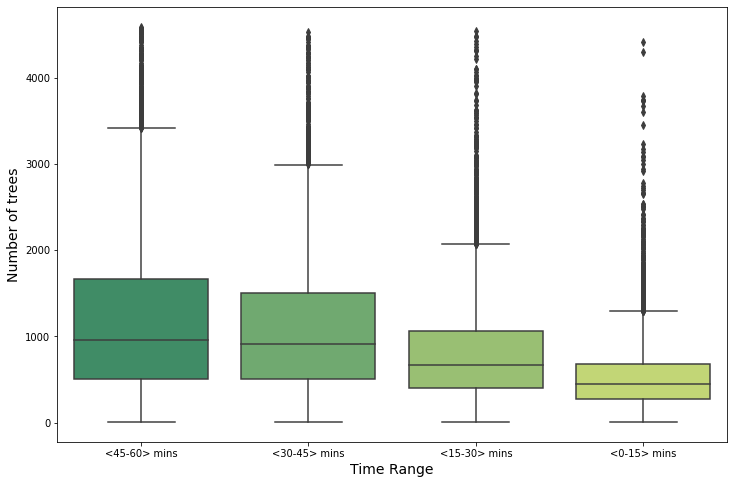

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Range_of_time',y='number_trees',data=new_one_without_outliers, palette="summer", order=["<45-60> mins", "<30-45> mins", "<15-30> mins", "<0-15> mins"])
ax.set_xlabel('Time Range', fontsize= 14)
ax.set_ylabel('Number of trees', fontsize= 14)

#plt.savefig('Boxplot_without_outlier.png', dpi = 300)
plt.show()

## Plotting some trips including the longest trip and outliers in the map (It is not done yet)

In [ ]:
from branca.element import Figure

In [ ]:
fig = Figure(height=550,width=750)
map1 = folium.Map(location=[all_tj.lat.mean(), all_tj.lon.mean()], control_scale=True)
fig.add_child(map1)

In [ ]:
# Finding the long trips
print("The mean of the distances are: ")
print(green_index_df['distance_km'].mean())
print("Trips longer than 20 km:  ")
green_index_df[green_index_df['distance_km'] > 20]

The mean of the distances are: 
1.8642962193864203
Trips longer than 20 km:  


,tripIndex,number_trees,time,distance_km,greenIndex_time,greenIndex_distance
17224,256135,24738,842,51.28402,29.380048,482.372477


In [ ]:
# The longest trip
#all_tj[all_tj['tripIndex'] == 256135]

In [ ]:
# Converting the column into list to have a list of the tripIndexes that are outliers. There are 239 trips
outliers_tripIndex = outliers_df['tripIndex'].tolist()
#outliers_tripIndex1 for testing. Because the loop takes a lot of time. 
outliers_tripIndex1 = [492, 29611]

longest_trip = [256135]

In [ ]:
# 239 tripIndexes of outliers...
#outliers_tripIndex

In [ ]:
'''trip_index_lat_lon = {}
for i, row in all_tj.iterrows():
  for x in outliers_tripIndex5:
    if all_tj['tripIndex'][i] == x:
      trip_index_lat_lon[x] = all_tj['lat-lon'][i]'''

In [ ]:
for i in range(len(outliers_tripIndex1)):
  print(i)
  df_green = df[df['tripIndex'] == li[i]]
    return df_green

In [ ]:
# Defining a function to gather all the lat and lon of the trip (all stops)
'''def finding_the_trip(df, li):
  new_li = []
  for x in li:
    new_li.append(df[df.tripIndex == x])
  new_df = pd.DataFrame(new_li, columns=['tripIndex','lat','lon','time','lat-lon','lat_next','lon_next','distance_km','distance_minutes','number_trees'])
  return new_df '''

'''def finding_the_trip(df, li):
  for x in li:
    return df[df['tripIndex'] == x]'''

def finding_the_trip(df, li):
  for i in range(len(li)):
    df_green = df[df['tripIndex'] == li[i]]
    return df_green


trip_lat_lon = finding_the_trip(all_tj,outliers_tripIndex)
'''trip_latlon_1 = finding_the_trip(all_tj,outliers_tripIndex1)
trip_latlon_2 = finding_the_trip(all_tj,outliers_tripIndex2)
trip_latlon_3 = finding_the_trip(all_tj,outliers_tripIndex3)
trip_latlon_4 = finding_the_trip(all_tj,outliers_tripIndex4)
trip_latlon_5 = finding_the_trip(all_tj,outliers_tripIndex5)'''

'trip_latlon_1 = finding_the_trip(all_tj,outliers_tripIndex1)\ntrip_latlon_2 = finding_the_trip(all_tj,outliers_tripIndex2)\ntrip_latlon_3 = finding_the_trip(all_tj,outliers_tripIndex3)\ntrip_latlon_4 = finding_the_trip(all_tj,outliers_tripIndex4)\ntrip_latlon_5 = finding_the_trip(all_tj,outliers_tripIndex5)'

In [ ]:
trip_lat_lon

,tripIndex,lat,lon,time,lat-lon,lat_next,lon_next,distance_km,distance_in_minutes,number_trees
80697,492,41.919669,12.494387,0,"(41.91966900706577, 12.494387352594256)",41.921086,12.494581,0.158200,0.001430,136
80698,492,41.921086,12.494581,120,"(41.92108593518859, 12.494581241554252)",41.922498,12.492589,0.227878,0.002442,103
80699,492,41.922498,12.492589,123,"(41.92249820161162, 12.492588588836378)",41.922626,12.495090,0.207997,0.002505,156
80700,492,41.922626,12.495090,123,"(41.92262576915319, 12.495090226989657)",41.921929,12.494358,0.098428,0.001011,131
80701,492,41.921929,12.494358,123,"(41.92192874437195, 12.494357505140318)",41.922368,12.495999,0.144618,0.001699,116
80702,492,41.922368,12.495999,123,"(41.92236762912652, 12.495998881378432)",41.921257,12.493225,0.261111,0.002988,138
80703,492,41.921257,12.493225,481,"(41.92125653525642, 12.493224916759944)",41.922369,12.492608,0.133704,0.001272,151
80704,492,41.922369,12.492608,481,"(41.92236874749873, 12.492608361458094)",41.923026,12.493459,0.101545,0.001075,161
80705,492,41.923026,12.493459,481,"(41.923026396257896, 12.493458724802656)",41.921596,12.492228,0.188818,0.001887,141
80706,492,41.921596,12.492228,1136,"(41.92159625930836, 12.492228176701436)",41.922298,12.492842,0.093076,0.000932,179


In [ ]:
for x in outliers_tripIndex:
  print(all_tj.loc[(all_tj['tripIndex']==x)])

Streaming output truncated to the last 5000 lines.
197369   (41.88004329939014, 12.577280426359335)  41.880043  12.577280   

        distance_km  distance_in_minutes  number_trees  
197351     0.185994             0.001675           242  
197352     0.089300             0.001005           230  
197353     0.224506             0.002025           246  
197354     0.167771             0.001531           224  
197355     0.108334             0.001279           246  
197356     0.086093             0.001008           284  
197357     0.180483             0.002173           252  
197358     0.381243             0.004304           306  
197359     0.272038             0.003271           214  
197360     0.308124             0.003313           270  
197361     0.236455             0.002479           200  
197362     0.161677             0.001724           242  
197363     0.117621             0.001143           202  
197364     0.339920             0.003822           204  
197365     0.210979

In [ ]:
trip_lat_lon1

,tripIndex,lat,lon,time,lat-lon,lat_next,lon_next,distance_km,distance_in_minutes,number_trees
80697,492,41.919669,12.494387,0,"(41.91966900706577, 12.494387352594256)",41.921086,12.494581,0.158200,0.001430,136
80698,492,41.921086,12.494581,120,"(41.92108593518859, 12.494581241554252)",41.922498,12.492589,0.227878,0.002442,103
80699,492,41.922498,12.492589,123,"(41.92249820161162, 12.492588588836378)",41.922626,12.495090,0.207997,0.002505,156
80700,492,41.922626,12.495090,123,"(41.92262576915319, 12.495090226989657)",41.921929,12.494358,0.098428,0.001011,131
80701,492,41.921929,12.494358,123,"(41.92192874437195, 12.494357505140318)",41.922368,12.495999,0.144618,0.001699,116
80702,492,41.922368,12.495999,123,"(41.92236762912652, 12.495998881378432)",41.921257,12.493225,0.261111,0.002988,138
80703,492,41.921257,12.493225,481,"(41.92125653525642, 12.493224916759944)",41.922369,12.492608,0.133704,0.001272,151
80704,492,41.922369,12.492608,481,"(41.92236874749873, 12.492608361458094)",41.923026,12.493459,0.101545,0.001075,161
80705,492,41.923026,12.493459,481,"(41.923026396257896, 12.493458724802656)",41.921596,12.492228,0.188818,0.001887,141
80706,492,41.921596,12.492228,1136,"(41.92159625930836, 12.492228176701436)",41.922298,12.492842,0.093076,0.000932,179


In [ ]:
trip_latlon_list = trip_lat_lon['lat-lon'].tolist()
#trip_latlon_list_2 = trip_latlon_2['lat-lon'].tolist()
'''trip_latlon_list_3 = trip_latlon_3['lat-lon'].tolist()
trip_latlon_list_4 = trip_latlon_3['lat-lon'].tolist()
trip_latlon_list_5 = trip_latlon_3['lat-lon'].tolist()'''

"trip_latlon_list_3 = trip_latlon_3['lat-lon'].tolist()\ntrip_latlon_list_4 = trip_latlon_3['lat-lon'].tolist()\ntrip_latlon_list_5 = trip_latlon_3['lat-lon'].tolist()"

In [ ]:
f1=folium.FeatureGroup("Trip 1")
#f2=folium.FeatureGroup("Trip 2")
'''f3=folium.FeatureGroup("Trip 3")
f4=folium.FeatureGroup("Trip 4")
f5=folium.FeatureGroup("Trip 5")'''


# Adding lines to the different feature groups
line_1=folium.vector_layers.PolyLine(trip_latlon_list,popup='<b>Path of Trip_1</b>',tooltip='trip_1',color='blue',weight=5).add_to(f1)
#line_2=folium.vector_layers.PolyLine(trip_latlon_list_2,popup='<b>Path of Trip_2</b>',tooltip='trip_2',color='red',weight=5).add_to(f2)
'''line_3=folium.vector_layers.PolyLine(trip_latlon_list_3,popup='<b>Path of Trip_3</b>',tooltip='trip_3',color='green',weight=5).add_to(f3)
line_4=folium.vector_layers.PolyLine(trip_latlon_list_4,popup='<b>Path of Trip_3</b>',tooltip='trip_4',color='yellow',weight=5).add_to(f4)
line_5=folium.vector_layers.PolyLine(trip_latlon_list_5,popup='<b>Path of Trip_3</b>',tooltip='trip_5',color='green',weight=5).add_to(f5)'''

"line_3=folium.vector_layers.PolyLine(trip_latlon_list_3,popup='<b>Path of Trip_3</b>',tooltip='trip_3',color='green',weight=5).add_to(f3)\nline_4=folium.vector_layers.PolyLine(trip_latlon_list_4,popup='<b>Path of Trip_3</b>',tooltip='trip_4',color='yellow',weight=5).add_to(f4)\nline_5=folium.vector_layers.PolyLine(trip_latlon_list_5,popup='<b>Path of Trip_3</b>',tooltip='trip_5',color='green',weight=5).add_to(f5)"

In [ ]:
f1.add_to(map)
#f2.add_to(map)
'''f3.add_to(map)
f4.add_to(map)
f5.add_to(map)'''

folium.LayerControl().add_to(map)
map